<a href="https://colab.research.google.com/github/NneomaOkafor/HousingCAD/blob/main/Nneoma_Okafor_Final_Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

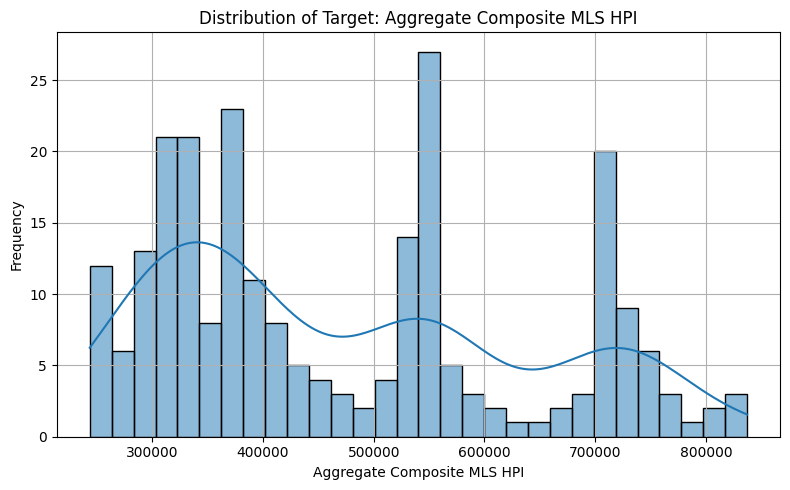

Summary statistics:
count       243.000000
mean     471894.650206
std      162802.625304
min      243500.000000
25%      333350.000000
50%      417100.000000
75%      562050.000000
max      837300.000000
dtype: float64
Total rows in X_lagged: 189
Not enough samples for 402/48 split. Adjusting split.
Best α (l1_ratio): 0.9,  Best λ: 45.9245

Selected 2660 variables out of 2870:


,0
CLAIMS_ALB_lag3,1140.521296
CLAIMS_ALB_lag4,1126.752474
CLAIMS_ALB_lag6,1112.600213
CLAIMS_ALB_lag5,1095.249733
CLAIMS_ALB_lag2,1087.464200
CLAIMS_ALB_lag1,1065.005984
CLAIMS_ALB,1040.496852
CLAIMS_QC,-846.639507
CRED_HOUS_non_MORT,-837.789462
CLAIMS_QC_lag2,-831.237505


Linear RMSE: 68889.11712124955
Folds used: 21 | Skipped due to NaNs: 0
Rolling CV (ML, params={'max_depth': 5, 'n_estimators': 50}): 21 folds used.
Params: {'max_depth': 5, 'n_estimators': 50}, Relative RMSE: 0.6949
Rolling CV (ML, params={'max_depth': None, 'n_estimators': 50}): 21 folds used.
Params: {'max_depth': None, 'n_estimators': 50}, Relative RMSE: 0.6856

Best Params: {'max_depth': None, 'n_estimators': 50}
Best Relative RMSE: 0.6856387422691776

Random Forest Test Metrics:
RMSE: 134883.72
MAE:  128391.79
MAPE: 23.32%

Linear Regression Test Metrics:
RMSE: 118380.63
MAE:  109519.80
MAPE: 20.03%


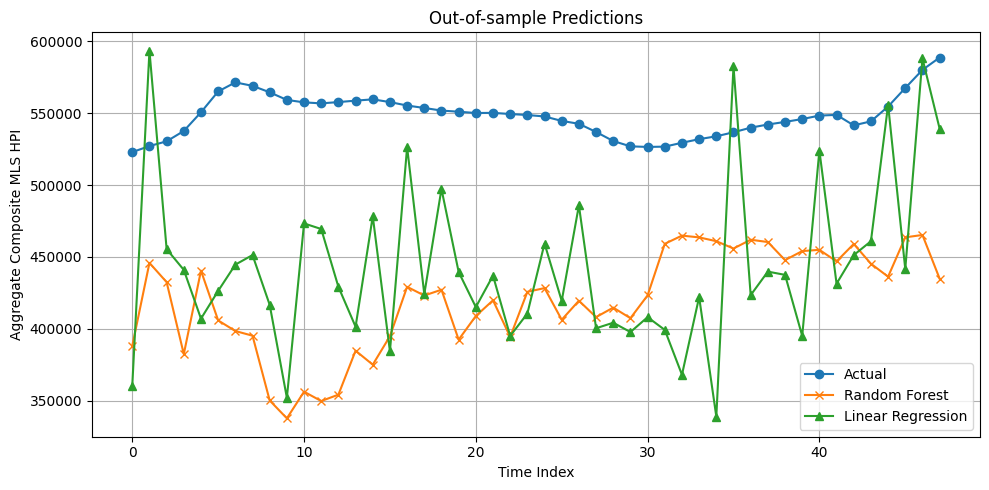

In [1]:
# 1. Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import subprocess

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Export environment dependencies
with open("requirements.txt", "w") as f:
    subprocess.run(["pip", "freeze"], stdout=f)

# 2. Load Dataset
df = pd.read_csv('/content/drive/MyDrive/Data Analysis/FINAL PROJECT/Python files/Project_set_in_use.csv')
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

# 3. Initial Cleaning
predictor_cols = df.columns.difference(["Date", "Aggregate Composite MLS HPI"])
X_raw = df[predictor_cols].drop(columns=[col for col in predictor_cols if "Average_Price" in col])
y = df["Aggregate Composite MLS HPI"].values

# 4. Target Distribution Analysis (Justifying Regression)
plt.figure(figsize=(8, 5))
sns.histplot(y, bins=30, kde=True)
plt.title("Distribution of Target: Aggregate Composite MLS HPI")
plt.xlabel("Aggregate Composite MLS HPI")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

print("Summary statistics:")
print(pd.Series(y).describe())

# Target is continuous, not categorical -> regression is appropriate

# 5. Feature Engineering – Lag Features
MAX_LAG = 6  # Based on domain knowledge: housing market dynamics respond over ~6 months
def make_lags(df_in, max_lag):
    out = df_in.copy()
    for lag in range(1, max_lag + 1):
        out = out.join(df_in.shift(lag).add_suffix(f"_lag{lag}"))
    return out

X_lagged = make_lags(X_raw, MAX_LAG)

# Combine with target and remove rows with NaNs from lagging
X_lagged["Aggregate Composite MLS HPI"] = df["Aggregate Composite MLS HPI"]
X_lagged = X_lagged.dropna()
y = X_lagged["Aggregate Composite MLS HPI"]
X_lagged = X_lagged.drop(columns=["Aggregate Composite MLS HPI"])

# 6. Train-Test Splitting (emulating realistic forecasting deployment)
N = len(X_lagged)
print(f"Total rows in X_lagged: {N}")

if N < 450:
    print("Not enough samples for 402/48 split. Adjusting split.")
    split_point = max(0, N - 48)
else:
    split_point = 402

X_train_full = X_lagged.iloc[:split_point]
y_train_full = y[:split_point]
X_test = X_lagged.iloc[split_point:]
y_test = y[split_point:]

X_tune = X_train_full.iloc[:302]
y_tune = y_train_full[:302]

# 7. Feature Selection with ElasticNetCV
# Uses TimeSeriesSplit to preserve temporal order (one-step-ahead emulation)
pipeline = Pipeline([
    ("scale", StandardScaler()),
    ("enet", ElasticNetCV(
        l1_ratio=[0.1, 0.5, 0.9],
        n_alphas=50,
        max_iter=10000,
        cv=TimeSeriesSplit(n_splits=5),  # Each fold uses past data to predict future data
        random_state=42
    ))
])

pipeline.fit(X_train_full, y_train_full)

best_alpha = pipeline.named_steps["enet"].l1_ratio_
best_lambda = pipeline.named_steps["enet"].alpha_
print(f"Best α (l1_ratio): {best_alpha},  Best λ: {best_lambda:.4f}")

coefs = pipeline.named_steps["enet"].coef_
selected = pd.Series(coefs, index=X_train_full.columns)
selected_nonzero = selected[selected != 0].sort_values(key=np.abs, ascending=False)
print(f"\nSelected {selected_nonzero.shape[0]} variables out of {len(coefs)}:")
display(selected_nonzero.head(20))

# Apply selected features
selected_features = selected_nonzero.index.tolist()
X_train_full = X_train_full[selected_features]
X_test = X_test[selected_features]
X_tune = X_tune[selected_features]

# 8. Rolling CV Functions (simulate one-step-ahead forecasting)
def rolling_cv_rmse_linear(X, y, window=120):
    """
    One-step-ahead rolling forecast using linear regression.
    Trains on a rolling window and predicts the next time step.
    """
    rmses = []
    skipped = 0
    for start in range(len(X) - window):
        X_train = X.iloc[start:start + window]
        y_train = y[start:start + window]
        X_val = X.iloc[start + window:start + window + 1]
        y_val = y[start + window:start + window + 1]

        if X_val.isnull().values.any() or y_val.isnull().values.any():
            skipped += 1
            continue

        model = LinearRegression()
        model.fit(X_train, y_train)
        pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, pred))
        rmses.append(rmse)

    print(f"Linear RMSE: {np.mean(rmses) if rmses else 'NaN'}")
    print(f"Folds used: {len(rmses)} | Skipped due to NaNs: {skipped}")
    return np.mean(rmses) if rmses else np.nan

def rolling_cv_rmse(model_class, params, X, y, window=120):
    """
    One-step-ahead rolling forecast using any ML model.
    """
    rmses = []
    for start in range(len(X) - window):
        X_train = X.iloc[start:start + window]
        y_train = y[start:start + window]
        X_val = X.iloc[start + window:start + window + 1]
        y_val = y[start + window:start + window + 1]

        if X_val.isnull().values.any() or y_val.isnull().values.any():
            continue

        model = model_class(**params, n_jobs=-1, random_state=42)
        model.fit(X_train, y_train)
        pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, pred))
        rmses.append(rmse)

    print(f"Rolling CV (ML, params={params}): {len(rmses)} folds used.")
    return np.mean(rmses) if rmses else np.nan

# 9. Hyperparameter Tuning
param_grid = {
    'n_estimators': [50],
    'max_depth': [5, None]
}
grid = ParameterGrid(param_grid)

window = 120
baseline_rmse = rolling_cv_rmse_linear(X_tune, y_tune, window=window)

best_params = None
best_rel_rmse = float('inf')

if np.isnan(baseline_rmse) or baseline_rmse == 0:
    print("Baseline RMSE is invalid. Skipping model comparison.")
else:
    for params in grid:
        ml_rmse = rolling_cv_rmse(RandomForestRegressor, params, X_tune, y_tune, window=window)
        rel_rmse = ml_rmse / baseline_rmse
        print(f"Params: {params}, Relative RMSE: {rel_rmse:.4f}")
        if not np.isnan(rel_rmse) and rel_rmse < best_rel_rmse:
            best_rel_rmse = rel_rmse
            best_params = params

    print("\nBest Params:", best_params)
    print("Best Relative RMSE:", best_rel_rmse)

# 10. Final Model Training and Evaluation
if best_params is not None:
    # Random Forest
    final_model = RandomForestRegressor(**best_params, random_state=42)
    final_model.fit(X_train_full, y_train_full)
    final_preds = final_model.predict(X_test)

    rf_rmse = np.sqrt(mean_squared_error(y_test, final_preds))
    rf_mae = mean_absolute_error(y_test, final_preds)
    rf_mape = mean_absolute_percentage_error(y_test, final_preds)

    print("\nRandom Forest Test Metrics:")
    print(f"RMSE: {rf_rmse:.2f}")
    print(f"MAE:  {rf_mae:.2f}")
    print(f"MAPE: {rf_mape * 100:.2f}%")

    # Linear Regression
    linear_model = LinearRegression()
    linear_model.fit(X_train_full, y_train_full)
    lin_preds = linear_model.predict(X_test)

    lin_rmse = np.sqrt(mean_squared_error(y_test, lin_preds))
    lin_mae = mean_absolute_error(y_test, lin_preds)
    lin_mape = mean_absolute_percentage_error(y_test, lin_preds)

    print("\nLinear Regression Test Metrics:")
    print(f"RMSE: {lin_rmse:.2f}")
    print(f"MAE:  {lin_mae:.2f}")
    print(f"MAPE: {lin_mape * 100:.2f}%")

    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(y_test)), y_test.values, label='Actual', marker='o')
    plt.plot(range(len(y_test)), final_preds, label='Random Forest', marker='x')
    plt.plot(range(len(y_test)), lin_preds, label='Linear Regression', marker='^')
    plt.title("Out-of-sample Predictions")
    plt.xlabel("Time Index")
    plt.ylabel("Aggregate Composite MLS HPI")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    print("Skipping final model training and plotting: No valid hyperparameters found.")
